In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [2]:
df = pd.read_csv('~/Desktop/vitaldb/clinical_data.csv')
df_lab = pd.read_csv('~/Desktop/vitaldb/lab_data.csv')

In [3]:
print([i for i in df.columns])

['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn', 'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe', 'intraop_epi', 'intraop_ca']


In [4]:
print(set(df_lab['name']))

{'ptinr', 'ast', 'tbil', 'lac', 'plt', 'na', 'tprot', 'p', 'hco3', 'alb', 'po2', 'aptt', 'crp', 'hct', 'cr', 'wbc', 'ammo', 'fib', 'pt%', 'gluc', 'bun', 'ph', 'ccr', 'pco2', 'k', 'ptsec', 'sao2', 'ica', 'esr', 'be', 'gfr', 'hb', 'cl', 'alt'}


In [5]:
df['icu_days'].value_counts()

0      5184
1       815
2        98
3        80
4        60
5        35
6        31
7        14
8         8
16        7
11        6
32        5
9         5
38        5
14        5
12        4
17        4
26        4
25        3
21        2
24        2
15        2
47        1
19        1
22        1
179       1
13        1
23        1
33        1
42        1
81        1
Name: icu_days, dtype: int64

## Naive Bayes

In [6]:
df2 = df.copy()

In [7]:
df.shape

(6388, 74)

In [8]:
#create binary values for icu stay: 0 not stay, 1 stay
df2['icu_binary'] = df2['icu_days'].apply(lambda x: 0 if x==0 else 1)
#create length of recording, anesthesia and operation
df2['case_len'] = df2['caseend'] - df2['casestart']
df2['ane_len'] = df2['aneend'] - df2['anestart']
df2['op_len'] = df2['opend'] - df2['opstart']
df2['adm_len'] = df2['adm'] - df2['dis']

In [9]:
#Label Encoding for age and sex to numeric conversion
le = LabelEncoder()

for col in ['age', 'sex']:
    df2[col] = le.fit_transform(df2[col].astype(str))

df2[['age', 'sex']]

,age,sex
0,75,1
1,50,1
2,59,1
3,72,1
4,63,1
...,...,...
6383,61,1
6384,66,1
6385,58,0
6386,19,0


In [10]:
#list of object with categorical values
objList = df2.select_dtypes(include = "object").columns
print (objList)

Index(['department', 'optype', 'dx', 'opname', 'approach', 'position',
       'ane_type', 'preop_ecg', 'preop_pft', 'cormack', 'airway', 'dltubesize',
       'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2'],
      dtype='object')


In [11]:
#hot encoding for other categorical variables
df2 = pd.get_dummies(df2, columns = objList)

In [12]:
#drop columns not used in our alalysis
df2= df2.drop(['case_len', 'height', 'weight', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis'], axis=1)

In [13]:
df2.fillna(-999, inplace=True)

In [14]:
#remove those features that have high number of missing data + case id and icu_days. 
l1 = [i for i in df2.columns]
features = [i for i in l1 if i not in ('caseid', 'icu_binary', 'icu_days', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'tubesize', 'lmasize', 'intraop_ebl', 'intraop_uo', 'intraop_rbc')]
x = df2[features]
y = df2['icu_days']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)

In [16]:
#Create a Gaussian Classifier
gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(x_test)

In [17]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.12128325508607199


In [18]:
df2['icu_binary'].value_counts()

0    5184
1    1204
Name: icu_binary, dtype: int64

0    5184
1    1204
Name: icu_binary, dtype: int64
['no stay', 'icu_stay']


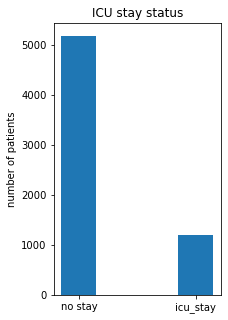

In [19]:
l1= df2['icu_binary'].value_counts()
l2 = ['no stay', 'icu_stay']

print(l1)
print(l2)
fig = plt.figure(figsize = (3, 5))
 
# creating the bar plot
plt.bar(l2, l1, width= 0.3)
 
plt.title("ICU stay status")
plt.ylabel("number of patients")
plt.show()

In [20]:
l = df2['icu_days'].value_counts()
a = df2['icu_days'].value_counts().rename_axis('icu_days').reset_index(name='patients')
print (a)

    icu_days  patients
0          0      5184
1          1       815
2          2        98
3          3        80
4          4        60
5          5        35
6          6        31
7          7        14
8          8         8
9         16         7
10        11         6
11        32         5
12         9         5
13        38         5
14        14         5
15        12         4
16        17         4
17        26         4
18        25         3
19        21         2
20        24         2
21        15         2
22        47         1
23        19         1
24        22         1
25       179         1
26        13         1
27        23         1
28        33         1
29        42         1
30        81         1


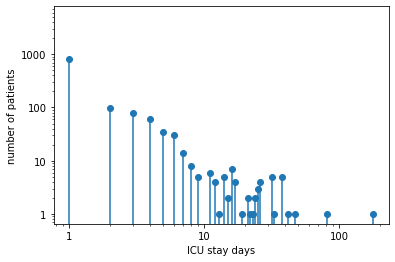

In [21]:
y = a['patients']
x = a['icu_days']
plt.yscale("log")
plt.xscale("log")
plt.xticks([10**0, 10**1, 10**2],[1, 10, 100])
plt.yticks([10**0, 10**1, 10**2, 10**3],[1, 10, 100, 1000])
plt.xlabel('ICU stay days')
plt.ylabel('number of patients')
plt.stem(x, y)
plt.show()

## Random Forest

In [22]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=500)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

In [23]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.852112676056338


No handles with labels found to put in legend.


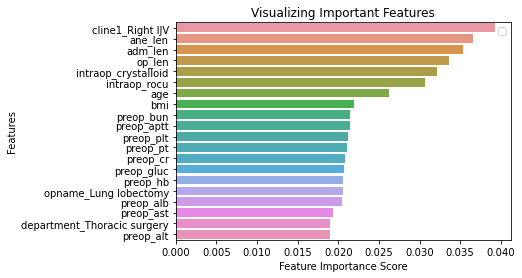

In [24]:
#finding top important features
feature_imp = pd.Series(clf.feature_importances_,index=features).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp[0:20], y=feature_imp.index[0:20])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [25]:
#ReGenerating the Model on Selected Features
top_features= feature_imp.index[0:100]
x = df2[top_features]
y = df2['icu_binary']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=12)
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=500)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train2,y_train2)

# prediction on test set
y_pred2=clf.predict(x_test2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))

Accuracy: 0.8943661971830986


## XGBoost

## Logistic Regression

In [26]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

/Users/msafariqariq/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.52%
